In [1]:
import numpy as np
import torch
import cv2
import os
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from functions.config import get_config
from functions.models.pose_hrnet import PoseHighResolutionNet

vid_path = 'files\\videos'
img_path = 'files\\images'
dataset_dir = 'finetune_dataset'
CTX = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
box_model = fasterrcnn_resnet50_fpn(pretrained=True)  # Add pretrained=True
box_model.to(CTX)
box_model.eval()

# initializing model
cfg = get_config(weights_path='pose_hrnet_w32_384x288.pth')
pose_model = PoseHighResolutionNet(cfg)
pose_model.init_weights(cfg.MODEL.PRETRAINED)
pose_model.to(CTX)
pose_model.eval()
0

c:\Users\Tijn\Documents\VSC\poses\Huggingface_poses\hf_pose\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tijn\Documents\VSC\poses\Huggingface_poses\hf_pose\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0

In [2]:
import os
from functions.processing.vid_check import check_vids, remove_blacklist
from functions.processing.vid_check import empty_imgdir
empty_imgdir(img_path)
idx = (4, -1)
n_check = 5
det_lim = 3
conf_thresh = 0.25
for path in [img_path, vid_path]:
    if not os.path.exists(path):
        os.makedirs(path)

blacklist = check_vids(box_model=box_model, pose_model=pose_model, vid_path=vid_path, img_path=img_path,
                       n_check=n_check, n_lim=det_lim, conf_thresh=conf_thresh, idx=idx)
remove_blacklist(blacklist)



Sampled 5 frames from files\videos\VID_20210727_115617~2.mp4 and saved to files\images.
Checked files\videos\VID_20210727_115617~2.mp4: 0 boxes not detected, 0 low confidence detections.
Sampled 5 frames from files\videos\VID_20211224_120346353.mp4 and saved to files\images.
Checked files\videos\VID_20211224_120346353.mp4: 0 boxes not detected, 0 low confidence detections.
Sampled 5 frames from files\videos\VID_20220616_205449.mp4 and saved to files\images.
Checked files\videos\VID_20220616_205449.mp4: 0 boxes not detected, 2 low confidence detections.


In [4]:
from functions.processing.video_processing import preprocess_video
import os
preprocess_video(os.path.join(vid_path, os.listdir(vid_path)[1]), img_path, fps=10)

Original FPS: 30.0
Total frames in video: 1534
Sampling 511 frames at 10 FPS from video: files\videos\VID_20211224_120346353.mp4
Sampled 511 frames from files\videos\VID_20211224_120346353.mp4


In [2]:
def analyze_image_2d(img_dir, img_file):
    import cv2
    from functions.boxmodel import get_box
    from functions.preprocess import preprocess_hrnet, preprocess_image
    from functions.keypoints import transform_keypoints_to_original
    image = preprocess_image(img_dir, img_file)
    box = get_box(image, box_model)
    input_tensor, transformation_matrix, _ = preprocess_hrnet(image, box)
    heatmaps = pose_model(input_tensor)
    original_keypoints, _ = transform_keypoints_to_original(heatmaps, input_tensor, transformation_matrix)
    keypoints = np.array([kp[:2] for kp in original_keypoints])
    return keypoints

def analyze_vid_2d(vidfile, img_path):
    img_dir = os.path.join(img_path, vidfile.split('.')[0])
    keypoints_batch = np.zeros((len(os.listdir(img_dir)), 17, 2))  # (frames, joints, coords)
    for i, img_file in enumerate(os.listdir(img_dir)):
        keypoints = analyze_image_2d(img_dir, img_file)
        keypoints_batch[i] = keypoints
        if i % 25 == 0:
            print(f'Processed {i} frames out of {len(os.listdir(img_dir))}')
    print(f'Processed {len(os.listdir(img_dir))} frames in total.')
    return keypoints_batch

In [4]:
vidfile = os.listdir(vid_path)[1]
keypoints_batch = analyze_vid_2d(vidfile, img_path)
keypoints_batch = keypoints_batch.reshape(1, keypoints_batch.shape[0], keypoints_batch.shape[1], keypoints_batch.shape[2])
keypoints_batch.shape


Processed 0 frames out of 511
Processed 25 frames out of 511
Processed 50 frames out of 511
Processed 75 frames out of 511
Processed 100 frames out of 511
Processed 125 frames out of 511
Processed 150 frames out of 511
Processed 175 frames out of 511
Processed 200 frames out of 511
Processed 225 frames out of 511
Processed 250 frames out of 511
Processed 275 frames out of 511
Processed 300 frames out of 511
Processed 325 frames out of 511
Processed 350 frames out of 511
Processed 375 frames out of 511
Processed 400 frames out of 511
Processed 425 frames out of 511
Processed 450 frames out of 511
Processed 475 frames out of 511
Processed 500 frames out of 511
Processed 511 frames in total.


(1, 511, 17, 2)

In [ ]:
import glob
from functions.models.hot_mixste import Model

def create_adaptive_args():
    import argparse
    args = argparse.Namespace()
    args.layers = 8
    args.channel = 512
    args.d_hid = 1024
    args.n_joints = 17
    args.out_joints = 17
    args.frames = 243  # Adapt to your video
    args.token_num = 81  # Adapt token count
    args.layer_index = 3
    args.checkpoint = 'files\\weights'
    return args

def normalize_screen_coordinates(X, w, h):
    assert X.shape[-1] == 2
    return X / w * 2 - [1, h / w]

def camera_to_world(X, R, t):
    return wrap(qrot, np.tile(R, (*X.shape[:-1], 1)), X) + t

def wrap(func, *args, unsqueeze=False):
    args = list(args)
    for i, arg in enumerate(args):
        if type(arg) == np.ndarray:
            args[i] = torch.from_numpy(arg)
            if unsqueeze:
                args[i] = args[i].unsqueeze(0)

    result = func(*args)

    if isinstance(result, tuple):
        result = list(result)
        for i, res in enumerate(result):
            if type(res) == torch.Tensor:
                if unsqueeze:
                    res = res.squeeze(0)
                result[i] = res.numpy()
        return tuple(result)
    elif type(result) == torch.Tensor:
        if unsqueeze:
            result = result.squeeze(0)
        return result.numpy()
    else:
        return result

def qrot(q, v):
    assert q.shape[-1] == 4
    assert v.shape[-1] == 3
    assert q.shape[:-1] == v.shape[:-1]

    qvec = q[..., 1:]
    uv = torch.cross(qvec, v, dim=len(q.shape) - 1)
    uuv = torch.cross(qvec, uv, dim=len(q.shape) - 1)
    return (v + 2 * (q[..., :1] * uv + uuv))

args = create_adaptive_args()
hotmodel = Model(args)
hotmodel.to(CTX)
model_dict = hotmodel.state_dict()
model_path = sorted(glob.glob(os.path.join(args.checkpoint, '*.pth')))[0]

pre_dict = torch.load(model_path)
model_dict = hotmodel.state_dict()
state_dict = {k: v for k, v in pre_dict.items() if k in model_dict.keys()}
model_dict.update(state_dict)
hotmodel.load_state_dict(model_dict)

hotmodel.eval()
video_length = keypoints_batch.shape[1]
n_chunks = video_length // args.frames + 1
offset = (n_chunks * args.frames - video_length) // 2
img_size = (640, 480)

frame_sum = 0
from tqdm import tqdm
import copy
for i in tqdm(range(n_chunks)):

    ## input frames
    start_index = i*args.frames - offset
    end_index = (i+1)*args.frames - offset

    low_index = max(start_index, 0)
    high_index = min(end_index, video_length)
    pad_left = low_index - start_index
    pad_right = end_index - high_index

    if pad_left != 0 or pad_right != 0:
        input_2D_no = np.pad(keypoints_batch[0][low_index:high_index], ((pad_left, pad_right), (0, 0), (0, 0)), 'edge')
    else:
        input_2D_no = keypoints_batch[0][low_index:high_index]
    
    joints_left =  [4, 5, 6, 11, 12, 13]
    joints_right = [1, 2, 3, 14, 15, 16]

    input_2D = normalize_screen_coordinates(input_2D_no, w=img_size[1], h=img_size[0])  

    input_2D_aug = copy.deepcopy(input_2D)
    input_2D_aug[ :, :, 0] *= -1
    input_2D_aug[ :, joints_left + joints_right] = input_2D_aug[ :, joints_right + joints_left]
    input_2D = np.concatenate((np.expand_dims(input_2D, axis=0), np.expand_dims(input_2D_aug, axis=0)), 0)
    
    input_2D = input_2D[np.newaxis, :, :, :, :]

    input_2D = torch.from_numpy(input_2D.astype('float32')).cuda()

    N = input_2D.size(0)
    with torch.no_grad():
        output_3D_non_flip = hotmodel(input_2D[:, 0])
        output_3D_flip     = hotmodel(input_2D[:, 1])
    output_3D_flip[:, :, :, 0] *= -1
    output_3D_flip[:, :, joints_left + joints_right, :] = output_3D_flip[:, :, joints_right + joints_left, :] 

    output_3D = (output_3D_non_flip + output_3D_flip) / 2

    if pad_left != 0 and pad_right != 0:
        output_3D = output_3D[:, pad_left:-pad_right]
        input_2D_no = input_2D_no[pad_left:-pad_right]
    elif pad_left != 0:
        output_3D = output_3D[:, pad_left:]
        input_2D_no = input_2D_no[pad_left:]
    elif pad_right != 0:
        output_3D = output_3D[:, :-pad_right]
        input_2D_no = input_2D_no[:-pad_right]

    output_3D[:, :, 0, :] = 0
    post_out = output_3D[0].cpu().detach().numpy()

    if i == 0:
        output_3d_all = post_out
    else:
        output_3d_all = np.concatenate([output_3d_all, post_out], axis = 0)


## save 3D keypoints
output_dir = 'results/'
os.makedirs(output_dir + 'output_3D/', exist_ok=True)
output_npz = output_dir + 'output_3D/' + 'output_keypoints_3d.npz'
np.savez_compressed(output_npz, reconstruction=output_3d_all)

print('Generating 3D pose successfully!')




100%|██████████| 3/3 [00:00<00:00,  7.31it/s]

Generating 3D pose successfully!


In [47]:
skeleton = [[16,14],[14,12],[17,15],[15,13],[12,13],[6,12],[7,13], [6,7],[6,8],
        [7,9],[8,10],[9,11],[2,3],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7]]
skel = [[coord-1 for coord in pair] for pair in skeleton]
skel

[[15, 13],
 [13, 11],
 [16, 14],
 [14, 12],
 [11, 12],
 [5, 11],
 [6, 12],
 [5, 6],
 [5, 7],
 [6, 8],
 [7, 9],
 [8, 10],
 [1, 2],
 [0, 1],
 [0, 2],
 [1, 3],
 [2, 4],
 [3, 5],
 [4, 6]]

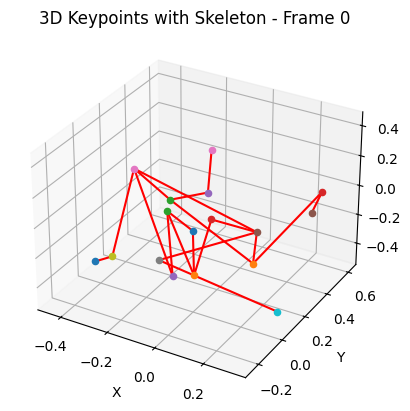

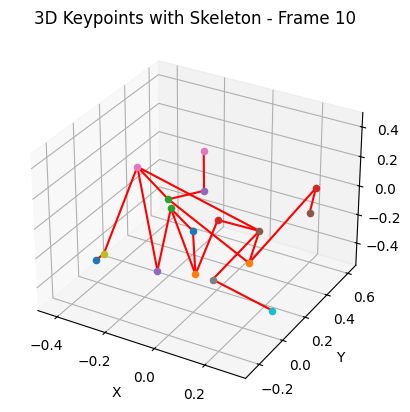

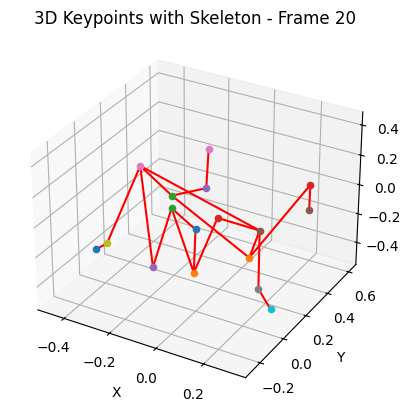

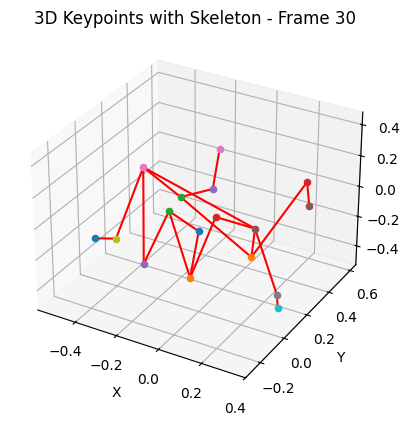

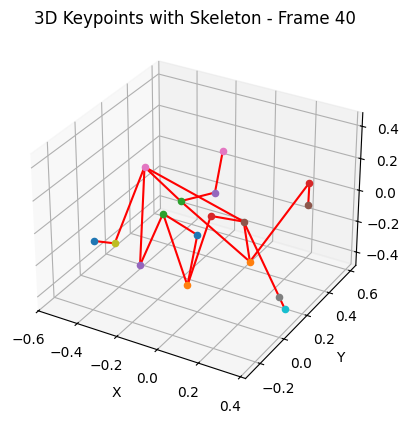

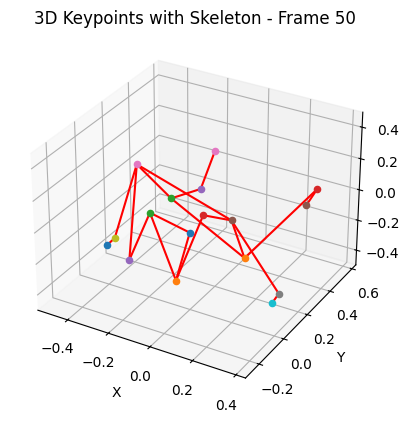

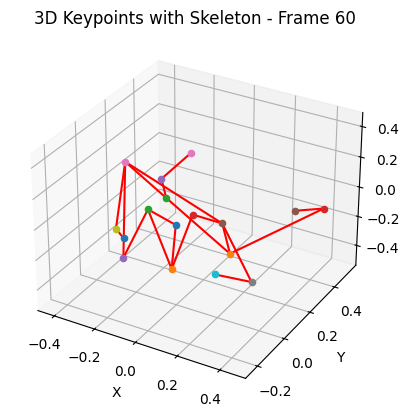

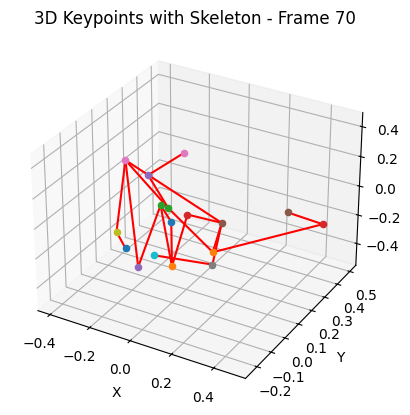

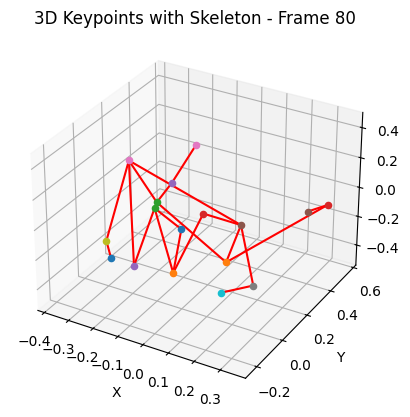

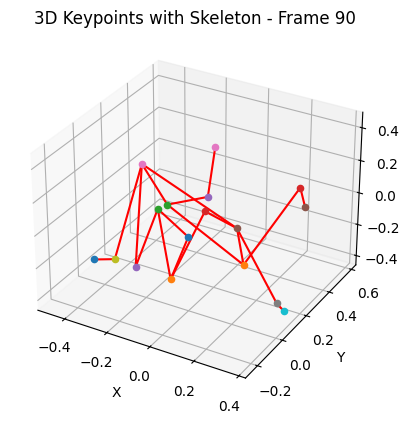

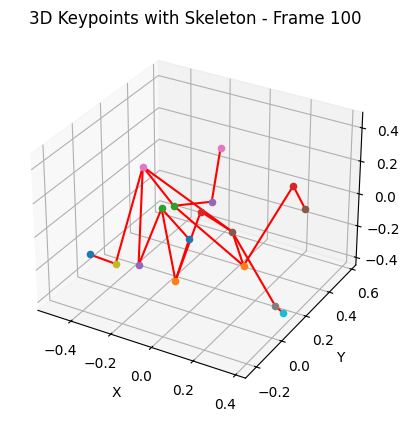

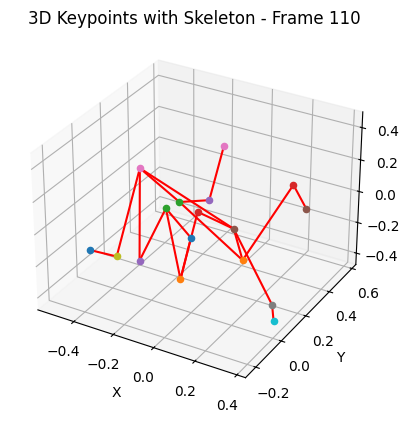

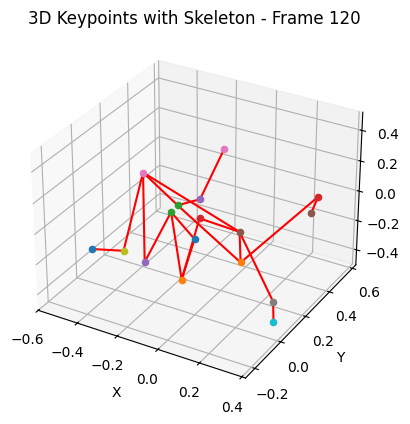

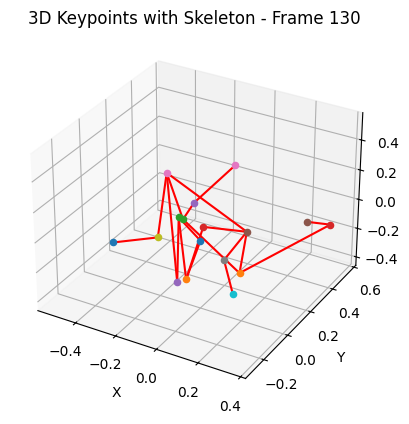

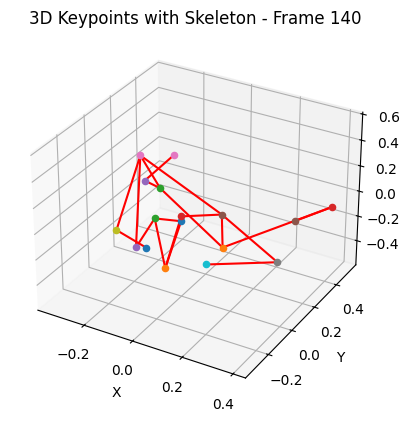

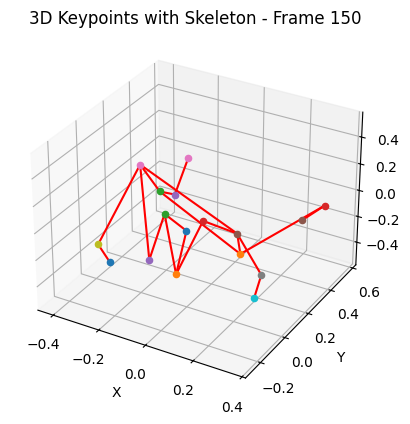

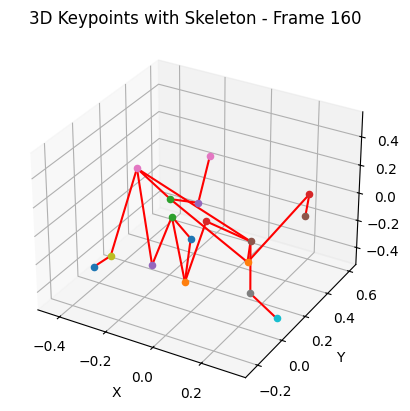

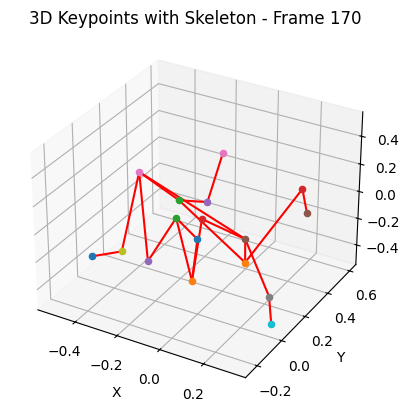

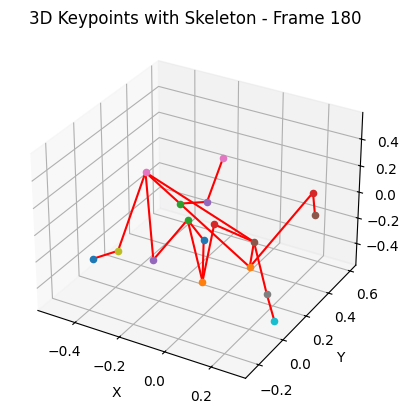

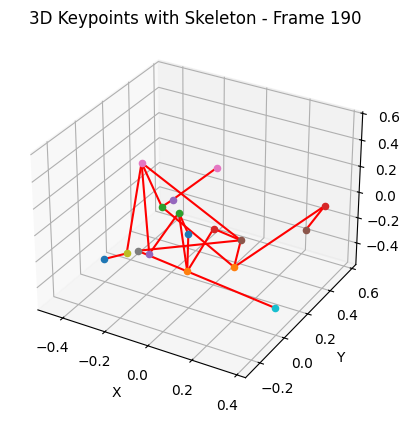

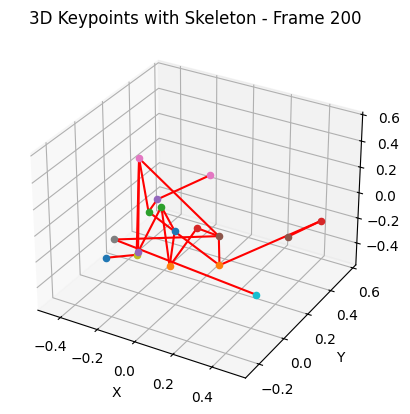

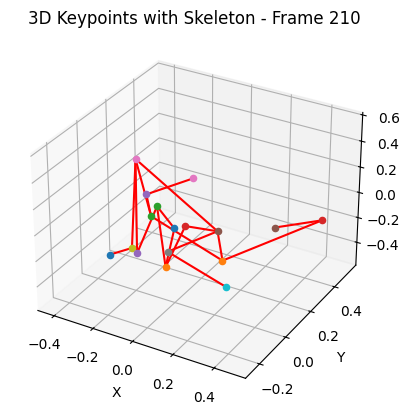

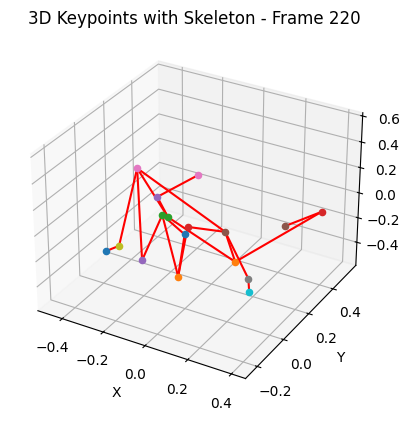

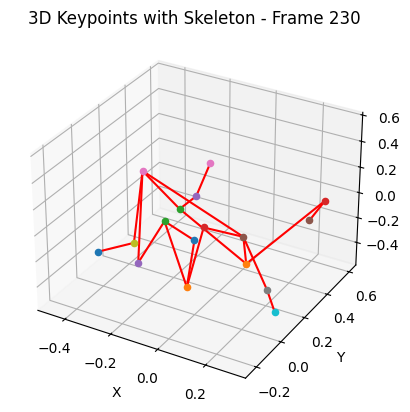

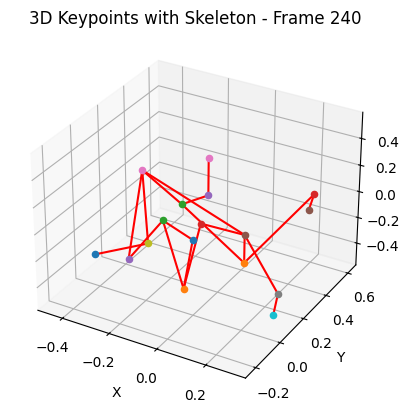

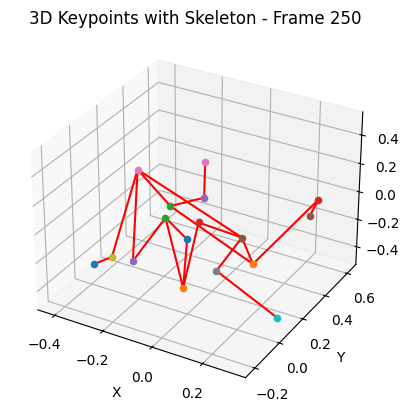

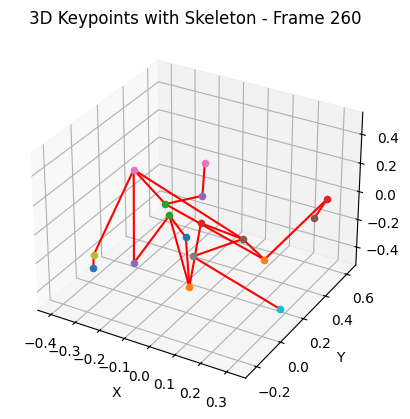

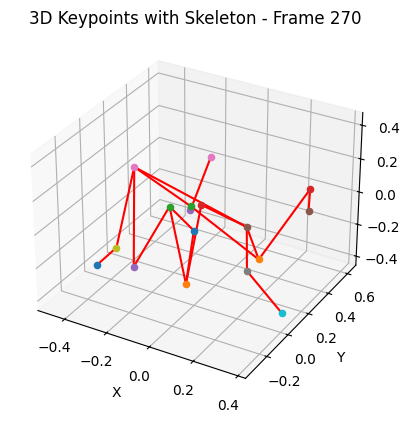

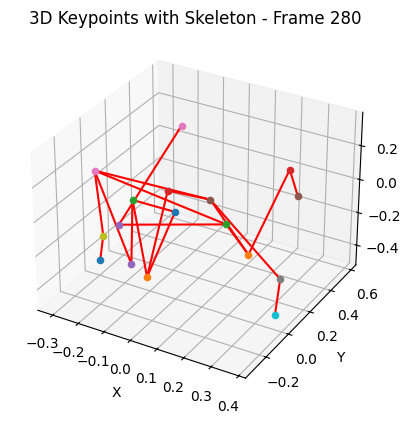

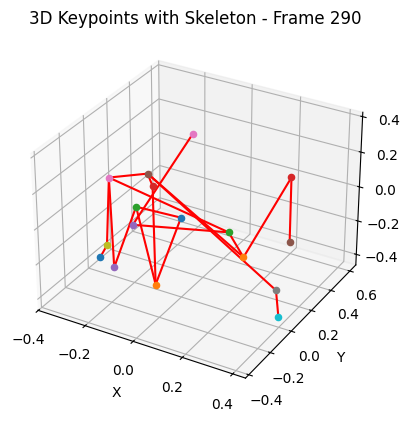

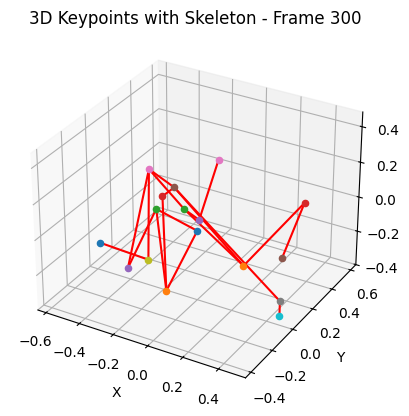

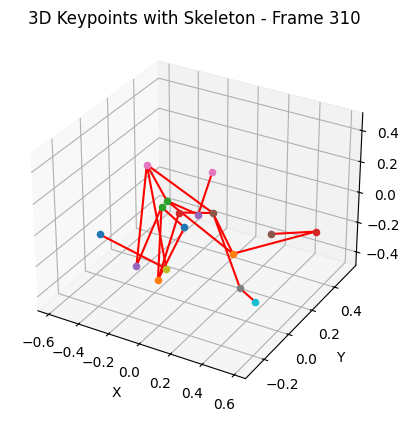

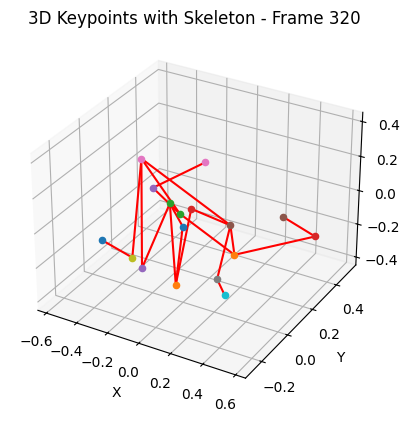

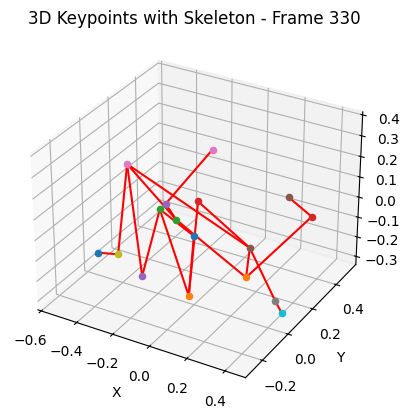

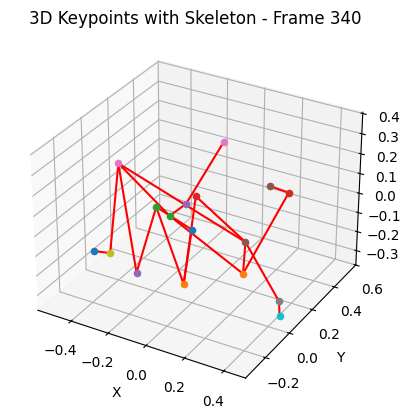

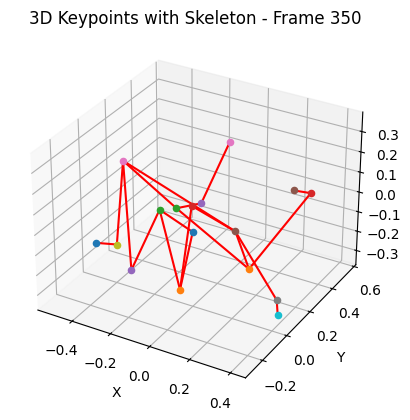

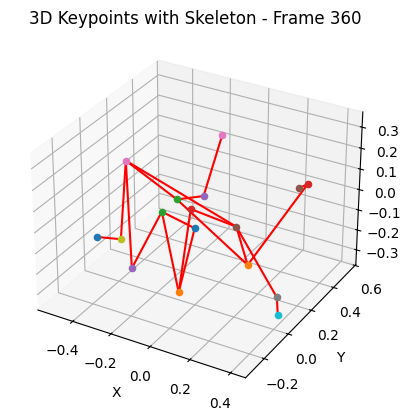

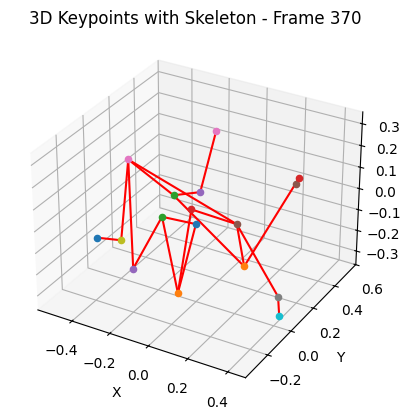

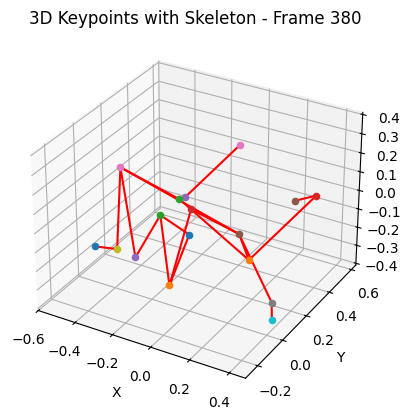

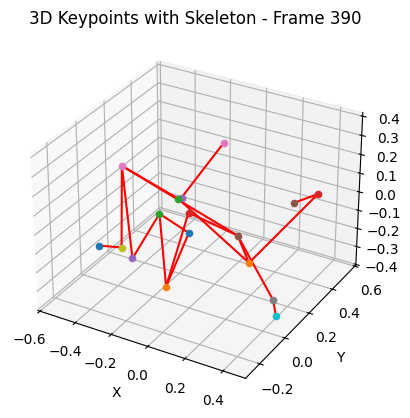

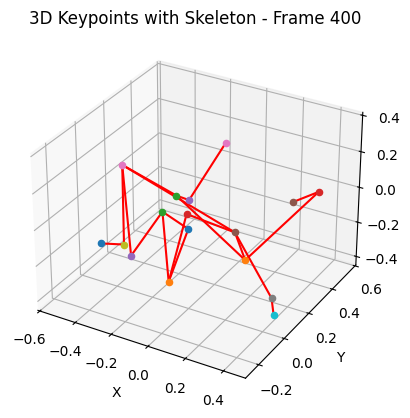

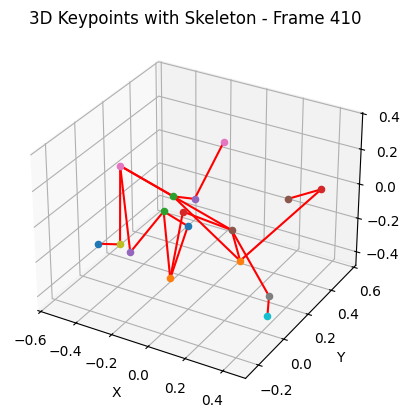

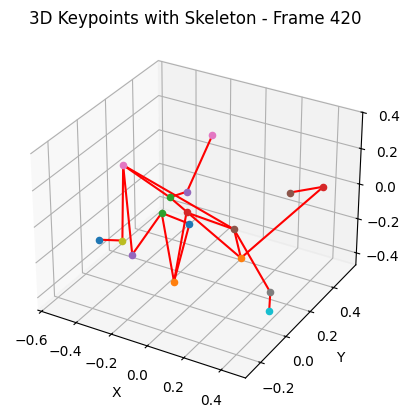

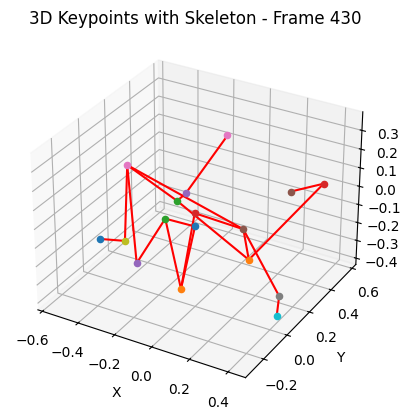

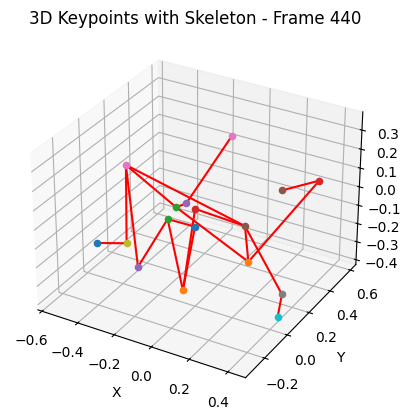

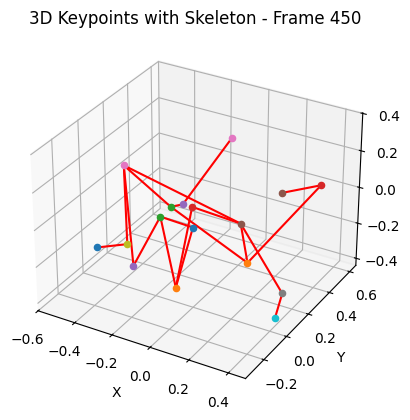

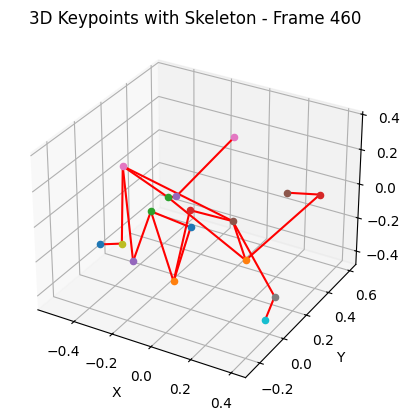

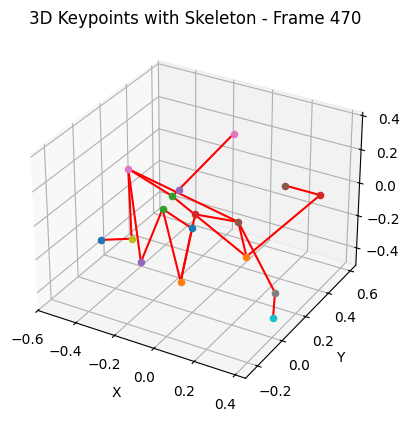

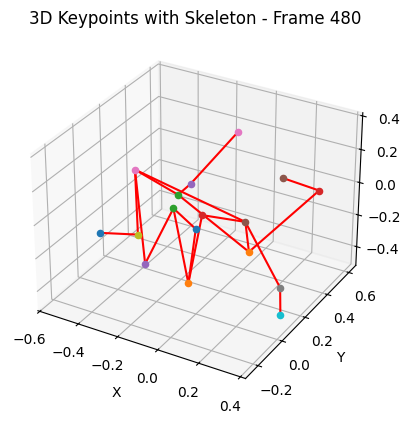

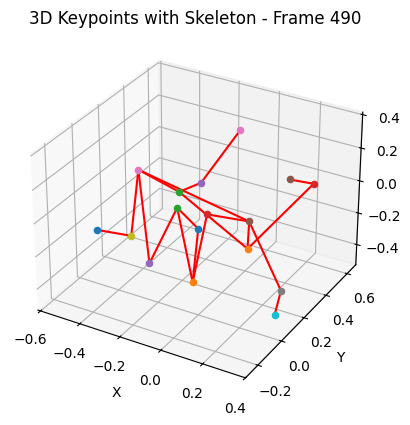

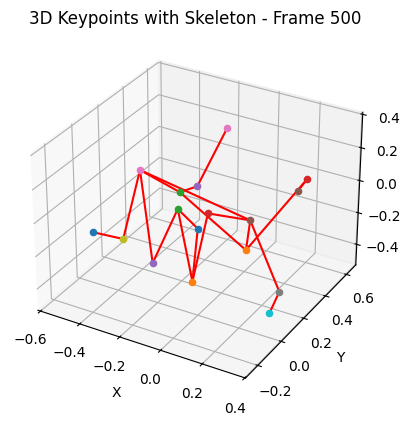

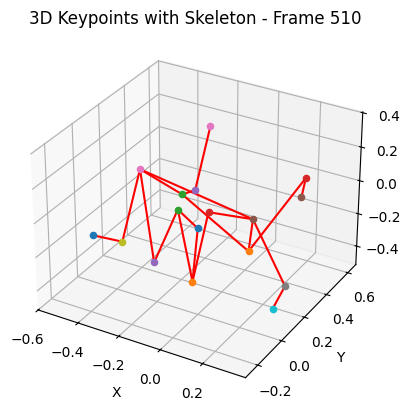

In [ ]:
import matplotlib.pyplot as plt
skeleton = [[16,14],[14,12],[17,15],[15,13],[12,13],[6,12],[7,13], [6,7],[6,8],
        [7,9],[8,10],[9,11],[2,3],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7]]
skel = [[coord-1 for coord in pair] for pair in skeleton]
def plot_3d_keypoints_with_skeleton(keypoints, skeleton, frame_index=0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each joint
    for joint in keypoints[frame_index]:
        ax.scatter(joint[0], joint[1], joint[2], marker='o')
    
    # Plot skeleton
    for pair in skeleton:
        joint1 = keypoints[frame_index][pair[0]]
        joint2 = keypoints[frame_index][pair[1]]
        ax.plot([joint1[0], joint2[0]], [joint1[1], joint2[1]], [joint1[2], joint2[2]], 'r-')
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'3D Keypoints with Skeleton - Frame {frame_index}')
    
    plt.show()
# Example usage
for frame_index in range(0, len(output_3d_all), 10):  # Adjust step for fewer frames
    plot_3d_keypoints_with_skeleton(output_3d_all, skel, frame_index)

1. Folders of videos :)
2. do random sampling on all videos, if confidence abysmally low or bbox unfindable, bin video as too low quality
3. Pick single video :)
4. Preprocess into separate frames :)
5. Calculate bbox for every frame :)
6. Decide if BBOX is recognizable in video -> bin videos where bbox is not found for at least 75% of frames
7. Calculate HRNET for first 15 frames -> if confidence < 0.5 bin the video
8. Calculate HRNET for all frames
9. Run 3d pose estimation of all frames
10. Retrieve 3d frame position of lower body joints
11. Observe changes in joints

In [14]:
tqdm

<module 'tqdm' from 'c:\\Users\\Tijn\\Documents\\VSC\\poses\\Huggingface_poses\\hf_pose\\Lib\\site-packages\\tqdm\\__init__.py'>

In [ ]:
from functions.dataset import HybridPoseDataset
from functions.dataset import prepare_cfg
from torchvision import transforms
from functions.finetune import JointsMSELoss
cfg = prepare_cfg(cfg)

# Usage - now compatible with official training:
train_dataset = HybridPoseDataset(
    cfg=cfg,
    annotation_file=os.path.join(dataset_dir, 'annotations', 'train.json'),
    img_dir=os.path.join(dataset_dir, 'images'),
    is_train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)
val_dataset = HybridPoseDataset(
    cfg=cfg,
    annotation_file=os.path.join(dataset_dir, 'annotations', 'val.json'),
    img_dir=os.path.join(dataset_dir, 'images'),
    is_train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)

loader_config = get_dataloader_config()
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=4,  # Start small for stability
    shuffle=True,
    **loader_config
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    **loader_config
)

# Set up model for training
pose_model.train()
criterion = JointsMSELoss(use_target_weight=True).to(CTX)

trainable_params = []
for name, param in pose_model.named_parameters():
    if any(layer in name for layer in ['final_layer', 'stage4']):
        param.requires_grad = True
        trainable_params.append(param)
    else:
        param.requires_grad = False

optimizer = optim.Adam(trainable_params, lr=1e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, epoch, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    num_batches = len(train_loader)
    
    for batch_idx, batch_data in enumerate(train_loader):
        try:
            # Handle both tuple and dict formats
            if isinstance(batch_data, (list, tuple)):
                if len(batch_data) == 4:
                    input_data, target, target_weight, meta = batch_data
                else:
                    input_data, target = batch_data[:2]
                    target_weight = None
            else:  # Dictionary format
                input_data = batch_data['image']
                target = batch_data['target']
                target_weight = batch_data.get('target_weight', None)
            
            # Move to device
            input_data = input_data.to(device)
            target = target.to(device)
            if target_weight is not None:
                target_weight = target_weight.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            output = model(input_data)
            
            # Calculate loss
            if target_weight is not None and hasattr(criterion, 'use_target_weight'):
                loss = criterion(output, target, target_weight)
            else:
                loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 5 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}/{num_batches}, Loss: {loss.item():.6f}')
                
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue
    
    avg_loss = total_loss / num_batches
    return avg_loss


# Run training
num_epochs = 15
best_val_loss = float('inf')

from functions.config import update_config
finetune_cfg = update_config(cfg, dataset_dir=dataset_dir)
train_loss = train_one_epoch(pose_model, train_loader, criterion, optimizer, 1, CTX)

print("Training completed!")

In [ ]:
# visualize the high-confidence results
for result in high_confidence_results:
    img_path = result['image_path']
    img = cv2.imread(img_path)
    img = cv2.resize(img, (640, 480))  # Resize for better visualization
    keypoints = result['keypoints']
    
    for keypoint in keypoints:
        x, y, score = keypoint
        if score > 0.5:  # Only draw keypoints with a reasonable score
            cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)
    
    cv2.imshow('High Confidence Keypoints', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()